In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.csv')
test_data = pd.read_csv('01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv')
test_0deg = pd.read_csv('02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv')
test_10deg = pd.read_csv('03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv')
test_25deg = pd.read_csv('04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669956 entries, 0 to 669955
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V       669956 non-null  float64
 1   I       669956 non-null  float64
 2   Temp    669956 non-null  float64
 3   V_avg   669956 non-null  float64
 4   I_avg   669956 non-null  float64
 5   SOC     669956 non-null  float64
dtypes: float64(6)
memory usage: 30.7 MB


In [4]:
data.describe()

,V,I,Temp,V_avg,I_avg,SOC
count,669956.000000,669956.000000,669956.000000,669956.000000,669956.000000,669956.000000
mean,0.710843,0.752365,0.672214,0.710363,0.752353,0.640461
std,0.252053,0.079163,0.332360,0.247668,0.056138,0.333134
min,0.000158,0.000000,0.002811,0.176340,0.597627,0.062822
25%,0.484394,0.751020,0.322932,0.484137,0.724062,0.292033
50%,0.749018,0.751020,0.915628,0.748360,0.751020,0.702539
75%,0.970067,0.762989,0.925131,0.969918,0.754660,0.993671
max,1.000000,1.000000,0.985835,0.977572,0.875519,1.000436


In [5]:
#Missing values
data.isnull().sum()

V        0
I        0
Temp     0
V_avg    0
I_avg    0
SOC      0
dtype: int64

In [6]:
X_train = data.drop(['SOC'], axis = 1)
y = data['SOC']

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train = scaler.fit_transform(y.values.reshape(-1, 1))


In [8]:
#Intialize the XGB REGRESSOR
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',random_state = 42)

In [9]:
#Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3,7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
#Grid search with cross validation
grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, cv = 2, scoring = 'r2', verbose = 1, n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 7],
                         'n_estimators': [100, 300], 'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [10]:
#Best Parameters :
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [11]:
#best r2 score on training data
grid_search.best_score_

0.9806991891848955

In [12]:
best_model = grid_search.best_estimator_

X_test =test_data.drop(['SOC'],axis = 1)
y_test = test_data['SOC']
y_test_scaled = scaler.transform(y.values.reshape(-1, 1))

y_pred_scaled = best_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared Error on test dataset :",mse)
print("R^2 score on test dataset :",r2)


Mean squared Error on test dataset : 0.0007105710278105477
R^2 score on test dataset : 0.9883705459637475


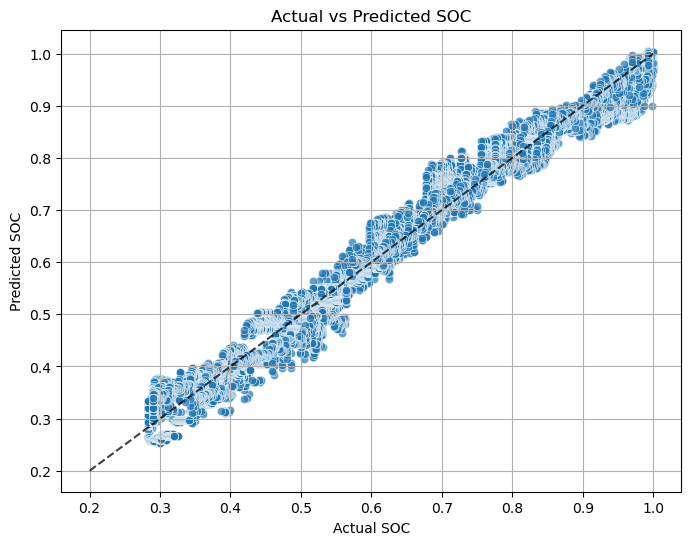

In [23]:
# Actual vs Predicted SOC
y_test_flat = np.ravel(y_test)
y_pred_flat = np.ravel(y_pred)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.7)
plt.xlabel('Actual SOC')
plt.ylabel('Predicted SOC')
lims = [0.2, 1] 
plt.plot(lims, lims, 'k--', alpha=0.75, label='Perfect Prediction')
plt.title('Actual vs Predicted SOC')
plt.grid(True)
plt.show()


## At  0 degree celsius

In [16]:
X_test_0 = test_0deg.drop(['SOC'],axis = 1)
y_test_0 = test_0deg['SOC']
y_test_scaled_0 = scaler.transform(y_test_0.values.reshape(-1, 1))

y_pred_scaled_0 = best_model.predict(X_test_0)
y_pred_0 = scaler.inverse_transform(y_pred_scaled_0.reshape(-1, 1))

mse_1 = mean_squared_error(y_test_0, y_pred_0)
r2_1= r2_score(y_test_0, y_pred_0)

print("Mean squared Error on test dataset :",mse_1)
print("R^2 score on test dataset :",r2_1)


Mean squared Error on test dataset : 0.000593563375324785
R^2 score on test dataset : 0.9917351561325526


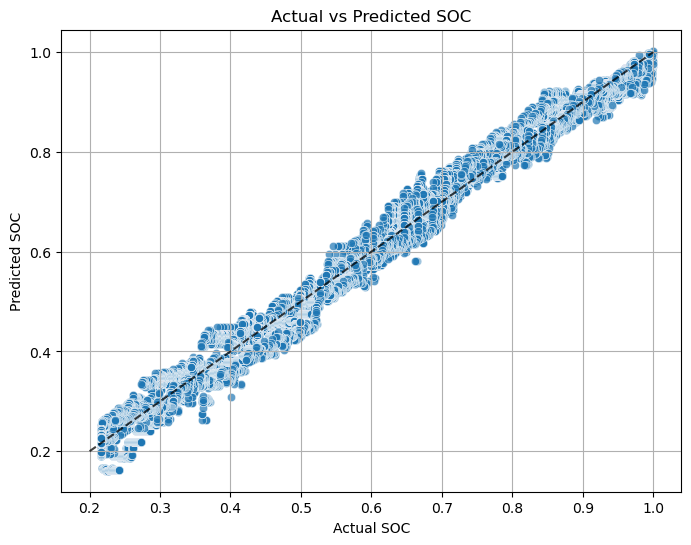

In [24]:
y_test_flat_0 = np.ravel(y_test_0)
y_pred_flat_0 = np.ravel(y_pred_0)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_flat_0, y=y_pred_flat_0, alpha=0.7)
plt.xlabel('Actual SOC')
plt.ylabel('Predicted SOC')
lims = [0.2, 1] 
plt.plot(lims, lims, 'k--', alpha=0.75, label='Perfect Prediction')
plt.title('Actual vs Predicted SOC')
plt.grid(True)
plt.show()


## At 10 degree celsius


In [17]:
X_test_10 = test_10deg.drop(['SOC'],axis = 1)
y_test_10 = test_10deg['SOC']
y_test_scaled_10 = scaler.transform(y_test_10.values.reshape(-1, 1))

y_pred_scaled_10 = best_model.predict(X_test_10)
y_pred_10 = scaler.inverse_transform(y_pred_scaled_10.reshape(-1, 1))

mse_2 = mean_squared_error(y_test_10, y_pred_10)
r2_2 = r2_score(y_test_10, y_pred_10)

print("Mean squared Error on test dataset :",mse_2)
print("R^2 score on test dataset :",r2_2)

Mean squared Error on test dataset : 0.000678239301477827
R^2 score on test dataset : 0.9909971171399103


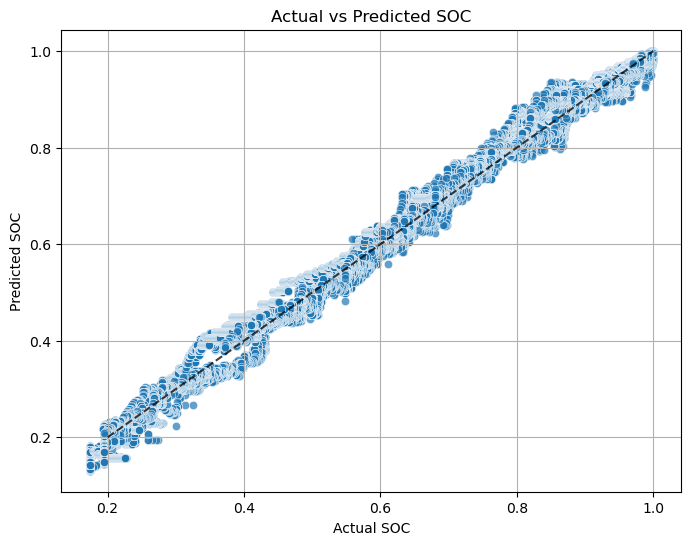

In [25]:
y_test_flat_10 = np.ravel(y_test_10)
y_pred_flat_10 = np.ravel(y_pred_10)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_flat_10, y=y_pred_flat_10, alpha=0.7)
plt.xlabel('Actual SOC')
plt.ylabel('Predicted SOC')
lims = [0.2, 1] 
plt.plot(lims, lims, 'k--', alpha=0.75, label='Perfect Prediction')
plt.title('Actual vs Predicted SOC')
plt.grid(True)
plt.show()


## At 25 degree celsius

In [19]:
X_test_25 = test_25deg.drop(['SOC'],axis = 1)
y_test_25 = test_25deg['SOC']
y_test_scaled_25 = scaler.transform(y_test_25.values.reshape(-1, 1))

y_pred_scaled_25 = best_model.predict(X_test_25)
y_pred_25 = scaler.inverse_transform(y_pred_scaled_25.reshape(-1, 1))

mse_3 = mean_squared_error(y_test_25, y_pred_25)
r2_3 = r2_score(y_test_25, y_pred_25)

print("Mean squared Error on test dataset :",mse_3)
print("R^2 score on test dataset :",r2_3)

Mean squared Error on test dataset : 0.0003989612012786867
R^2 score on test dataset : 0.9952618482441297


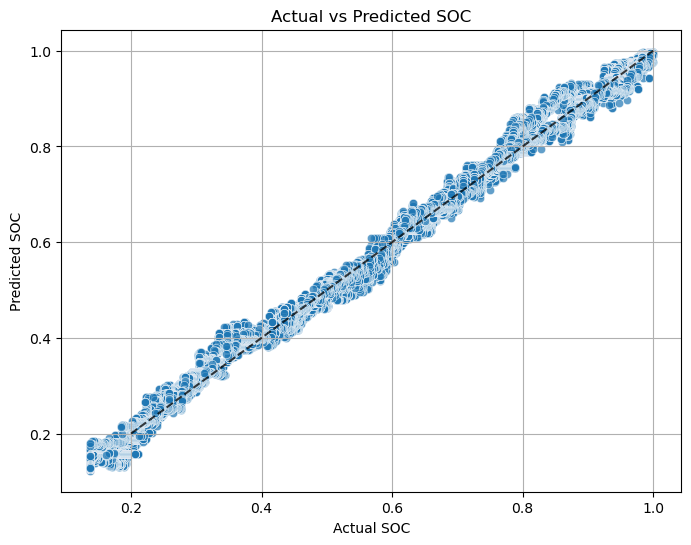

In [26]:
y_test_flat_25 = np.ravel(y_test_25)
y_pred_flat_25 = np.ravel(y_pred_25)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_flat_25, y=y_pred_flat_25, alpha=0.7)
plt.xlabel('Actual SOC')
plt.ylabel('Predicted SOC')
lims = [0.2, 1] 
plt.plot(lims, lims, 'k--', alpha=0.75, label='Perfect Prediction')
plt.title('Actual vs Predicted SOC')
plt.grid(True)
plt.show()


In [27]:
best_model.save_model('SOC_prediction_xgb.json')